### 今回は[このノートブック](https://github.com/syuntoku14/Shumi-Note/blob/main/notebooks/exercise_RL.ipynb)をjaxで書き換えて強化学習のテーブル形式の理解を深めます．

強化学習についての詳しい解説は上のノートブックを参照してください．

まずはMDPのコードを書いていきます．

In [80]:
import numpy as np
from typing import NamedTuple

S = 100 #state_size
A = 10  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99 

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)
print(mdp.rew.shape)
print(mdp.P.shape)

(100, 10)
(100, 10, 100)


MDPが全てわかっている時に, 解く方法は動的計画法で行えることがわかっています．

In [84]:
import jax
import jax.numpy as jnp

@jax.jit
def Bellman_expected_operator(mdp:MDP, q:jnp.array, pi:np.array):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    assert pi.shape == (S,A)
    # 行動のサメーション取ると行動価値関数から価値関数になる．
    v = (pi * q).sum(axis=1)
    P_v = mdp.P @ v

    return rew + mdp.gamma * P_v
@jax.jit
def Bellman_optimal_operator(mdp:MDP, q:jnp.array):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    #行列形式の演算も最適作用素で行いたいので，1番価値が高い,行動の列だけを各状態で１にする．
    pi_max = jnp.zeros((S,A))
    pi_max = pi_max.at[np.arange(S),q.argmax(axis=1)].set(1)

    return Bellman_expected_operator(mdp,q,pi_max)


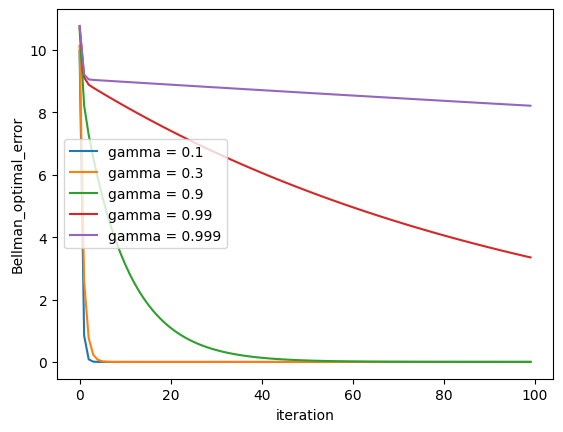

In [85]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S, A = mdp.S, mdp.A

gammas = [0.1, 0.3, 0.9, 0.99, 0.999]


for gamma in gammas:
    q_before = jax.random.uniform(key,shape=[S, A])  #Q関数の初期値を一様分布から作成
    errors = []

    mdp = mdp._replace(gamma=gamma)
    # ベルマン最適作用素を繰り返し適用して、収束するか確認してみます
    for i in range(100):
        
        q_after = Bellman_optimal_operator(mdp, q_before)
        errors.append(np.abs(q_after - q_before).max())
        q_before = q_after

    plt.plot(errors, label= f'gamma = {gamma}')
plt.xlabel('iteration')
plt.ylabel('Bellman_optimal_error')
plt.legend()

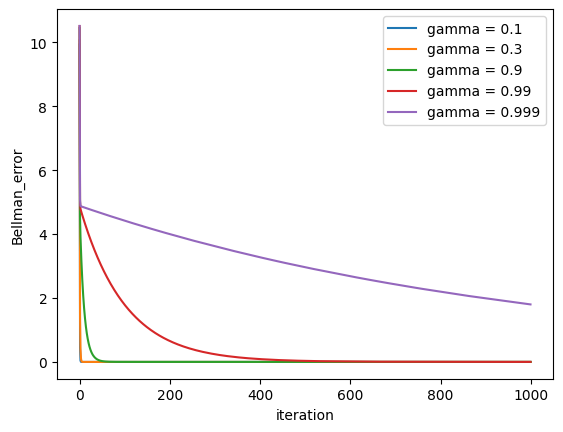

In [86]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S,A = mdp.S, mdp.A

pi = jax.random.uniform(key=key,shape=(S,A))
pi = pi / jnp.sum(pi,axis=1,keepdims=True)

gammas = [0.1,0.3,0.9,0.99,0.999]
for gamma in gammas:
    q_before = jax.random.uniform(key = key,shape = (S,A))
    errors = []

    mdp = mdp._replace(gamma = gamma)
    

    for i in range(1000):
        q_after = Bellman_expected_operator(mdp,q_before,pi)
        errors.append(np.abs(q_after - q_before).max())
        q_before = q_after
    
    plt.plot(errors,label=f'gamma = {gamma}')

plt.ylabel('Bellman_error')
plt.xlabel('iteration')
plt.legend()

